In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

In [2]:
def func(filename, sp_filename, n_maxiter=3, norm_radius=5.5, recentering_boxsize=5):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    mag: Object magnitude.
    n_maxiter: Maximum number of iteration in ePSF analysis.
    norm_radius: Number of undersampled pixels 
                 which determines the radius for flux normalization of ePSF.
    recentering_boxsize: Number of undersampled pixels
                 which determines the box size for ePSF recentering calculation.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
    n_oversample = 4 # Number of oversampling for ePSF.
#    n_maxiter    = 3 # Max. number of iteration for making ePSF.
#    mag = 12.0       # Object magnitude.
    threshold_level = 100.
#    print("Analyzing {}...".format(filename))
    max_dist_pix = 0.1
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
#    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.colorbar()
#    plt.show()
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
    norm = simple_norm(data, 'sqrt', percent=99.)
    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (px)')
    plt.ylabel('Y (px)')
    plt.colorbar()
    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold_level*std_val)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
    print(stars_tbl)
    
    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
    nrows = 10
    ncols = 10
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
    ax = ax.ravel()
    for i in range(nrows*ncols):
        norm = simple_norm(stars[i], 'log', percent=99.)
        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
    plt.show()
    
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=False,
                               norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                               center_accuracy=0.001)
    epsf, fitted_stars = epsf_builder(stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (oversampled pix)')
    plt.ylabel('Y (oversampled pix)')
    plt.colorbar()
    plt.show()
    
    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        diff = fitted_stars.center_flat-np.array([o[2]-1.,o[3]-1.])
        p = np.where(diff[:,0]**2.+diff[:,1]**2.<max_dist_pix**2.)
        if np.size(p) == 1:
            xc_array.append([o[2]-1., o[3]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[p[0][0]][0],
                             fitted_stars.center_flat[p[0][0]][1]])
    xc_array = np.array(xc_array)
    print(xc_array.shape)

    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0]
    dy = xc_array[:,3] - xc_array[:,1]
#    dx = dx - np.mean(dx)
#    dy = dy - np.mean(dy)
    plt.scatter(dx, dy, marker='x')
    plt.xlabel('$\Delta$x (px)')
    plt.ylabel('$\Delta$y (px)')
    plt.xlim([-0.05,0.05])
    plt.ylim([-0.05,0.05])
    plt.show()

    plt.scatter(dx, dy, marker='x')
    plt.xlabel('$\Delta$x (px)')
    plt.ylabel('$\Delta$y (px)')
    plt.xlim([-1.05,1.05])
    plt.ylim([-1.05,1.05])
    plt.show()
    
    # Making pix-phase error data.
    plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
    plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.05,0.05])
    plt.xlabel('Pixel phase')
    plt.ylabel('Deviation (px)')
    plt.legend()
    plt.show()
    
    
    plt.axes().set_aspect('equal')
    plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
               angles='xy', scale_units='xy', scale=0.05)
    plt.xlabel('X (px)')
    plt.ylabel('Y (px)')
    plt.xlim([0, 1920])
    plt.ylim([0, 1920])
    plt.show()
    
    # Calculating stddev.
    print("STDDEV DX: {} px".format(np.std(dx)))
    print("STDDEV DY: {} px".format(np.std(dy)))
#    stddx = np.std(dx)
#    stddy = np.std(dy)
##    stddr = np.std(np.sqrt(dx*dx+dy*dy))
    
#    meandx = np.mean(dx)
#    meandy = np.mean(dy)
    
#    stddr = np.std(np.sqrt((dx-meandx)**2.+(dy-meandy)**2.))
#    return stddx, stddy, stddr, meandx, meandy

    # Making pix-phase error data.
    plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
    plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
    plt.xlim([-0.5,0.5])
#    plt.ylim([-0.05,0.05])
    plt.xlabel('Pixel phase')
    plt.ylabel('Deviation (px)')
    plt.legend()
    plt.show()

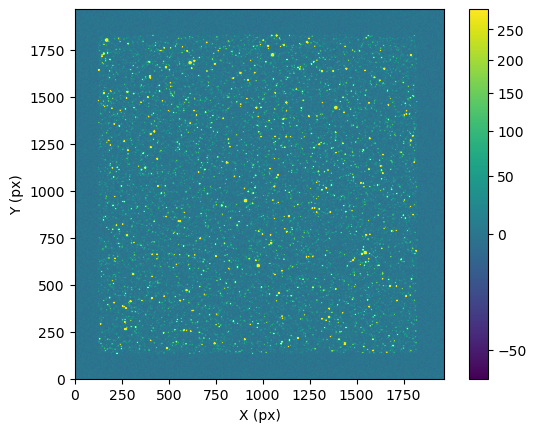

 x    y  
---- ----
 223  136
1367  149
1585  151
 489  164
1135  172
1535  172
1692  177
1436  186
 590  187
1096  187
 ...  ...
 282 1783
1238 1788
 700 1790
1233 1792
 169 1802
1001 1802
1244 1811
1548 1814
1045 1827
1072 1827
Length = 369 rows


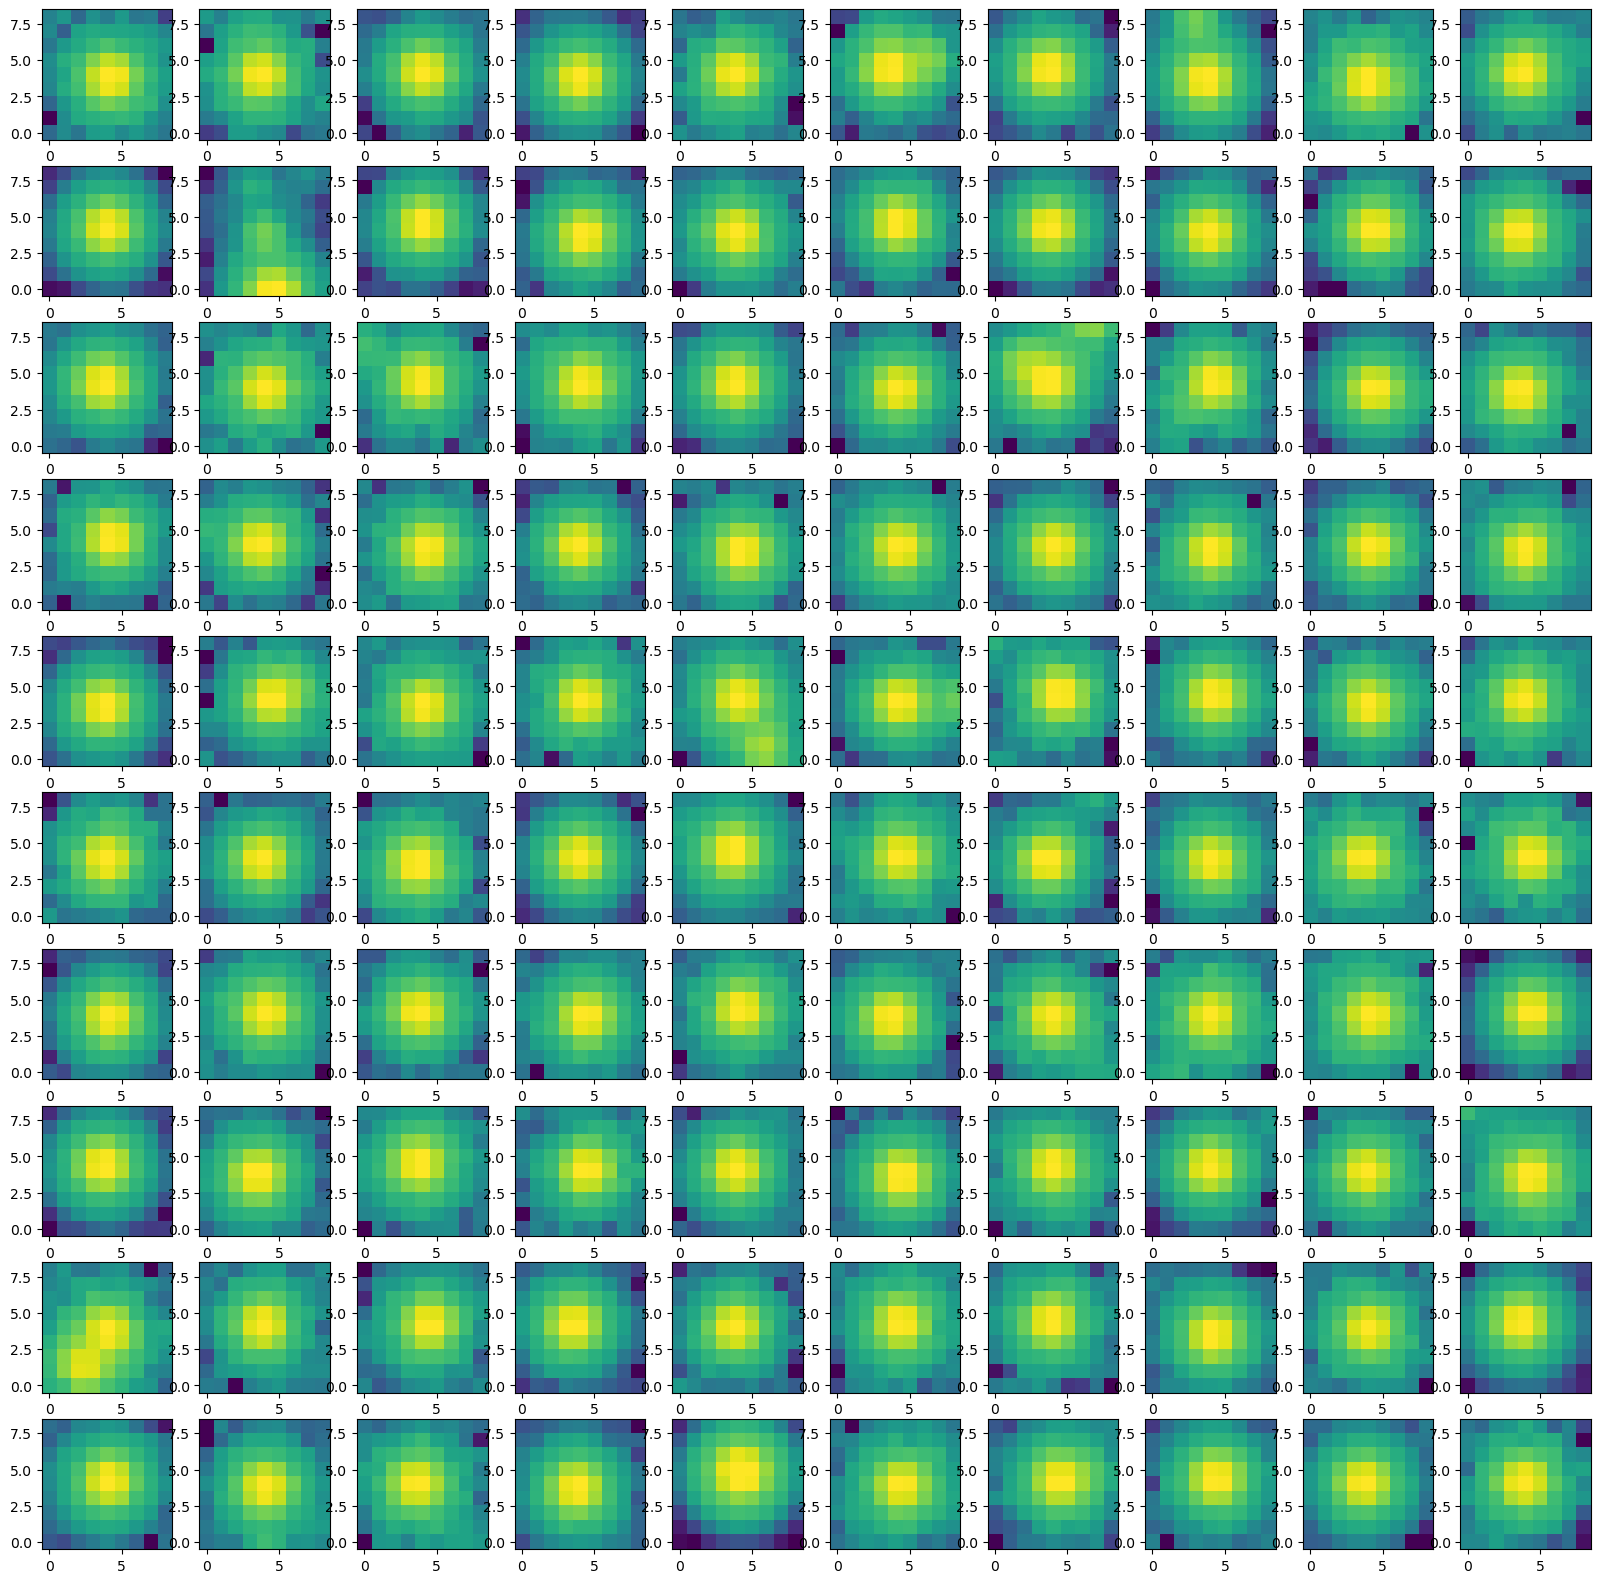

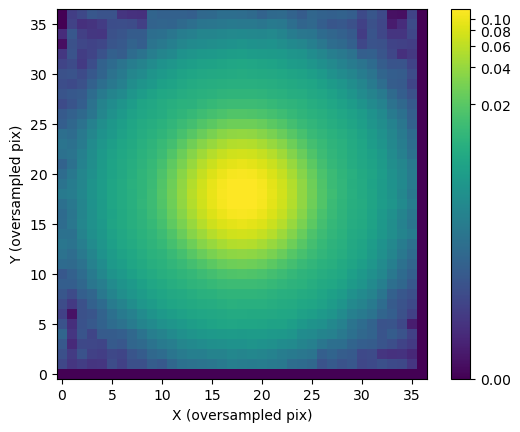

(356, 4)


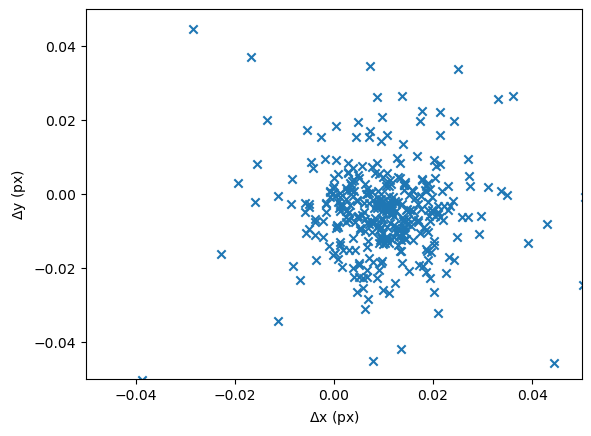

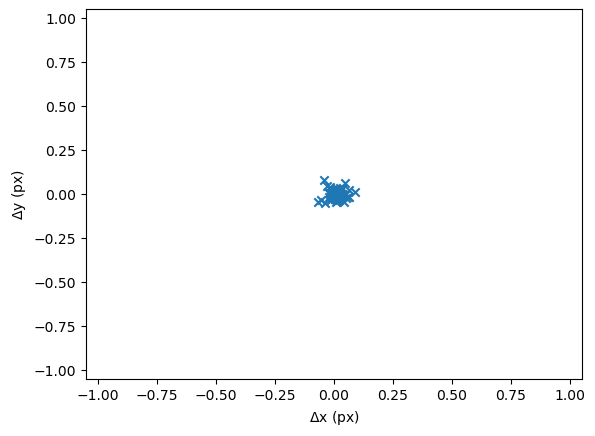

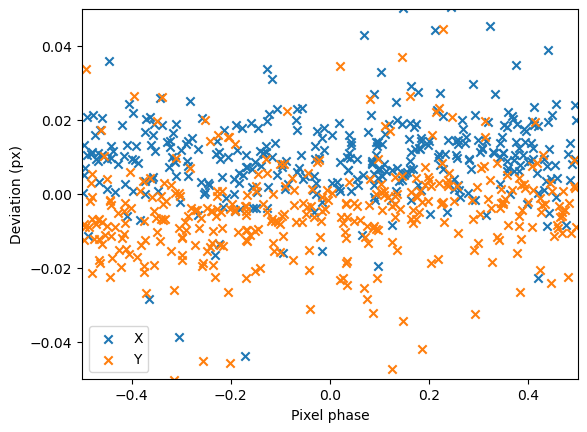

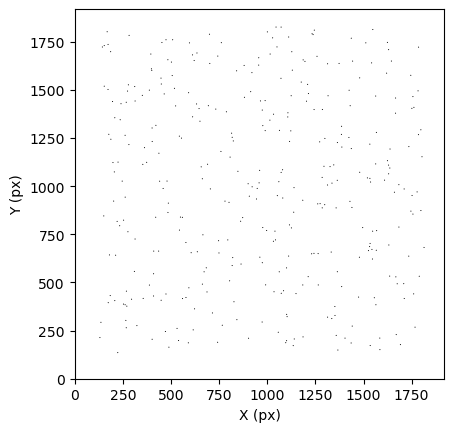

STDDEV DX: 0.013653792414093358 px
STDDEV DY: 0.013532939402544589 px


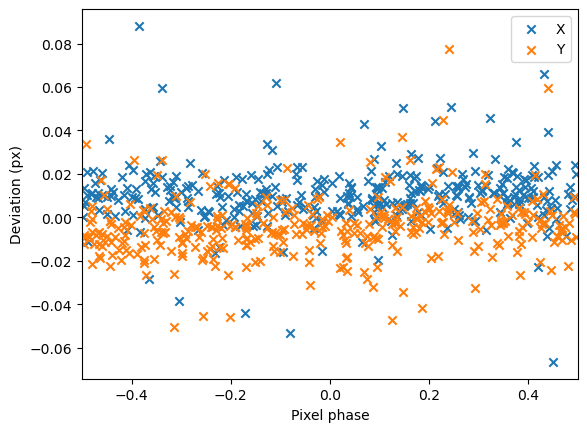

In [3]:
func('img_ver1_2_B.fits', 'galcen_star_plate.csv')